# Data Analysis Interview Challenge: Ultimate Company

### Import Libraries For the Project:

In [1]:
#conda install -c conda-forge xgboost

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from datetime import datetime

# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score


## Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
logins = pd.read_json('logins.json')
print(logins.shape)
logins.info()

(93142, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.head(7)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16


In [5]:
logins=logins.sort_values('login_time')
print(f'First login:\t{logins.login_time.iloc[0]}')
print(f'Last login:\t{logins.login_time.iloc[-1]}')
print(f'in a span of {logins.login_time.iloc[-1]-logins.login_time.iloc[0]}')

First login:	1970-01-01 20:12:16
Last login:	1970-04-13 18:57:38
in a span of 101 days 22:45:22


### **93142 logins in a span of 102 days starting from January 1st 1970. without missing or misformat**

In [6]:
logins["cnts"] = 1
logins = logins.set_index(['login_time'])
logins.head()

,cnts
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [7]:
# resample the index, so that time is represented in 15min chunks
logins_15 = logins.resample('15Min').sum()
print(logins_15.shape)
logins_15.head()

(9788, 1)


,cnts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


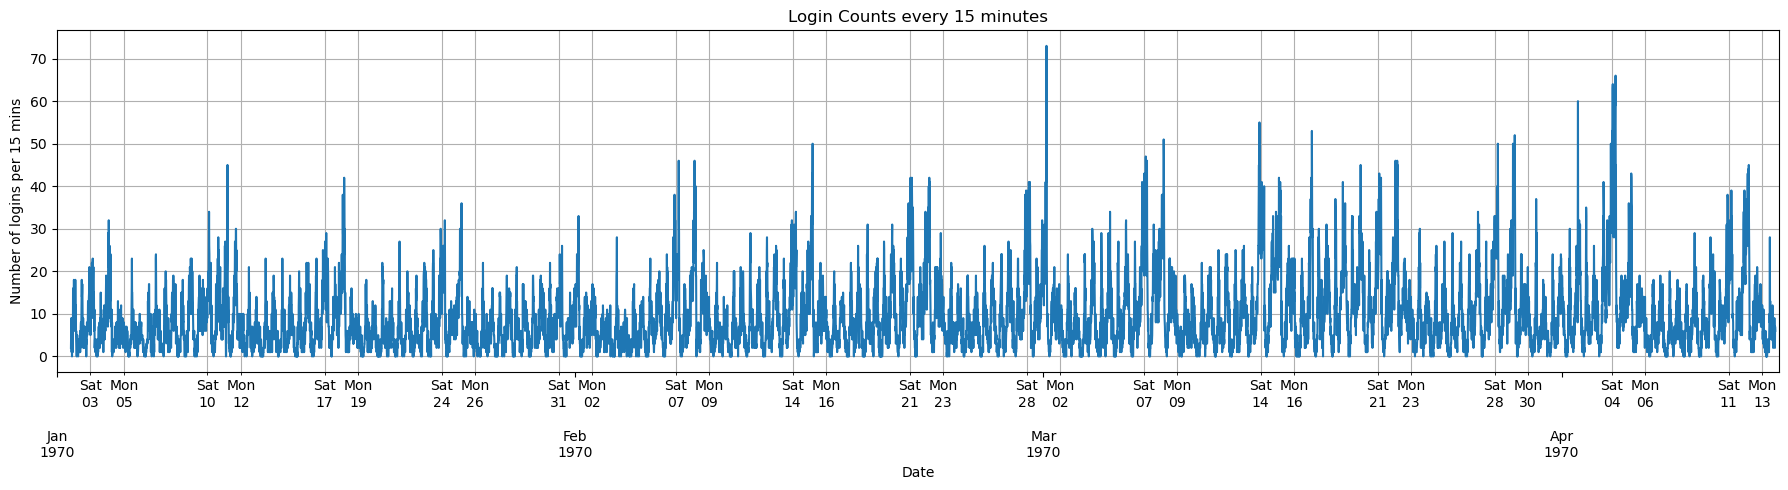

In [8]:
import matplotlib.dates as dates
fig, ax = plt.subplots(figsize = (18,5))
plt.plot(logins_15.index,logins_15.cnts)
plt.title('Login Counts every 15 minutes')
plt.ylabel('Number of logins per 15 mins')
plt.xlabel('Date')
plt.xlim(pd.Timestamp('1970-01-01'),pd.Timestamp('1970-04-14'))

ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=([5,0]),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%a\n%d'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.show()


#### It shows Weekly and Daily Patterns in login counts , with a significant increase during weekends

In [9]:
hourly_logins = logins.resample('H').sum()

# make a column that identify the day of week; Monday=0, Sunday=6
#day_of_week = list(daily_logins.index.dayofweek)
hourly_logins['day_of_week'] = hourly_logins.index.dayofweek
# add column with just the hour (omiting the date)
hourly_logins['hour'] = [time.hour for time in hourly_logins.index]
hourly_logins['day'] = hourly_logins.index.day
hourly_logins['month'] = hourly_logins.index.month

hourly_logins

,cnts,day_of_week,hour,day,month
login_time,,,,,
1970-01-01 20:00:00,24,3,20,1,1
1970-01-01 21:00:00,9,3,21,1,1
1970-01-01 22:00:00,21,3,22,1,1
1970-01-01 23:00:00,58,3,23,1,1
1970-01-02 00:00:00,53,4,0,2,1
...,...,...,...,...,...
1970-04-13 14:00:00,32,0,14,13,4
1970-04-13 15:00:00,19,0,15,13,4
1970-04-13 16:00:00,22,0,16,13,4


In [10]:
hourly_logins.describe()

,cnts,day_of_week,hour,day,month
count,2447.000000,2447.000000,2447.000000,2447.000000,2447.000000
mean,38.063752,3.035554,11.496935,14.569268,2.259093
std,30.752820,2.013031,6.923355,8.684673,1.017375
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,15.000000,1.000000,5.500000,7.000000,1.000000
50%,29.000000,3.000000,11.000000,14.000000,2.000000
75%,52.000000,5.000000,17.000000,22.000000,3.000000
max,237.000000,6.000000,23.000000,31.000000,4.000000


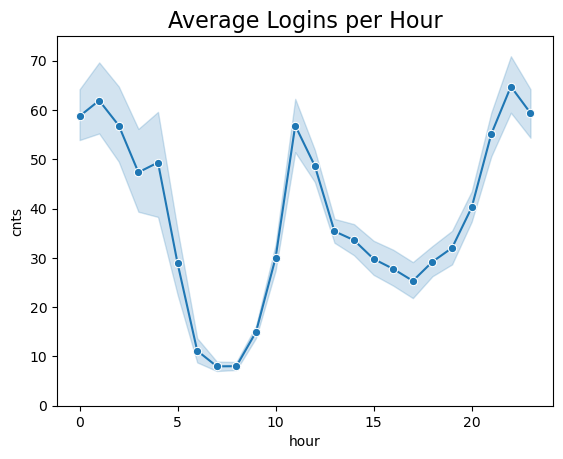

In [11]:
# Visualize average of logins per month.
sns.lineplot(data=hourly_logins, x='hour', y='cnts',
            markers=True, marker='o')
plt.title('Average Logins per Hour', fontsize=16)
ax = plt.gca()
#ax.set_xticks([1, 2, 3, 4])
#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr']) 
plt.ylim(0,75)
plt.show()

<AxesSubplot: title={'center': 'Average Hourly Login Counts'}, xlabel='hour', ylabel='cnts'>

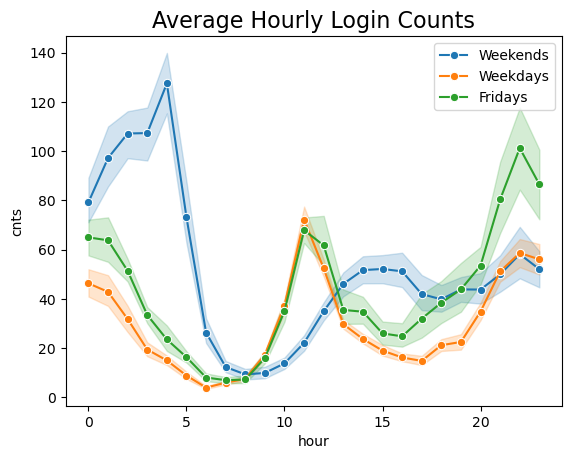

In [12]:
plt.title('Average Hourly Login Counts', fontsize=16)
sns.lineplot(data=hourly_logins[hourly_logins.day_of_week>4], x='hour', y='cnts',
            markers=True, marker='o',label="Weekends")
sns.lineplot(data=hourly_logins[hourly_logins.day_of_week<4], x='hour', y='cnts',
            markers=True, marker='o',label="Weekdays")
sns.lineplot(data=hourly_logins[hourly_logins.day_of_week==4], x='hour', y='cnts',
            markers=True, marker='o',label="Fridays")

<AxesSubplot: xlabel='hour', ylabel='cnts'>

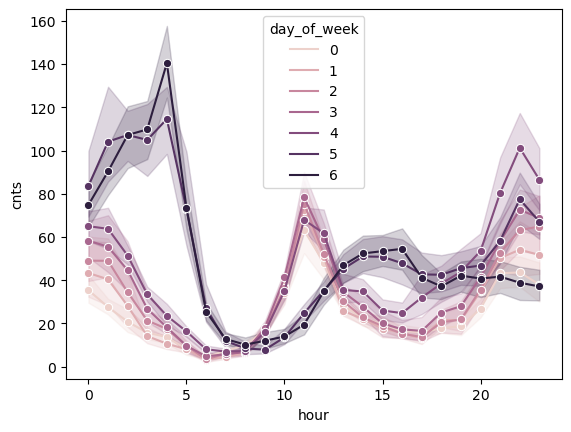

In [13]:
sns.lineplot(data=hourly_logins, x='hour', y='cnts',
            markers=True, marker='o', hue=hourly_logins.day_of_week)

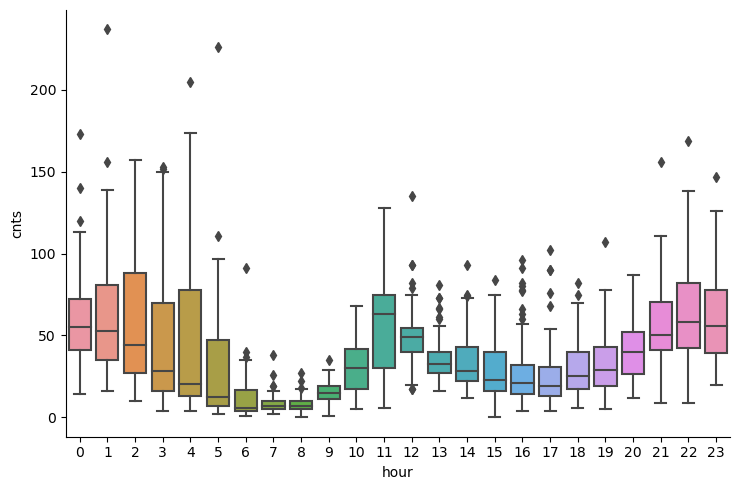

In [14]:
# The details of hourly distribution using a bar and wisker plot
sns.catplot(x = 'hour', y = 'cnts', data = hourly_logins, kind = 'box', aspect=1.5)

,index,cnts
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


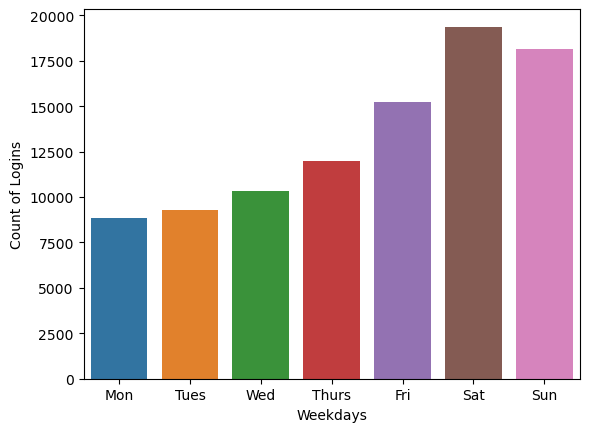

In [15]:
count_weekday = hourly_logins.loc[:,['cnts','day_of_week']].groupby('day_of_week').sum()
count_weekday.index = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
count_weekday.reset_index(inplace=True)
sns.barplot(x='index', y='cnts', data=count_weekday)
plt.xlabel('Weekdays')
plt.ylabel('Count of Logins')
count_weekday

In [16]:
Daily_logins = logins.resample('D').sum()
Daily_logins['day_of_week'] = Daily_logins.index.dayofweek
Daily_logins['Month'] = Daily_logins.index.month

Daily_logins

,cnts,day_of_week,Month
login_time,,,
1970-01-01,112,3,1
1970-01-02,681,4,1
1970-01-03,793,5,1
1970-01-04,788,6,1
1970-01-05,459,0,1
...,...,...,...
1970-04-09,818,3,4
1970-04-10,1009,4,4
1970-04-11,1352,5,4


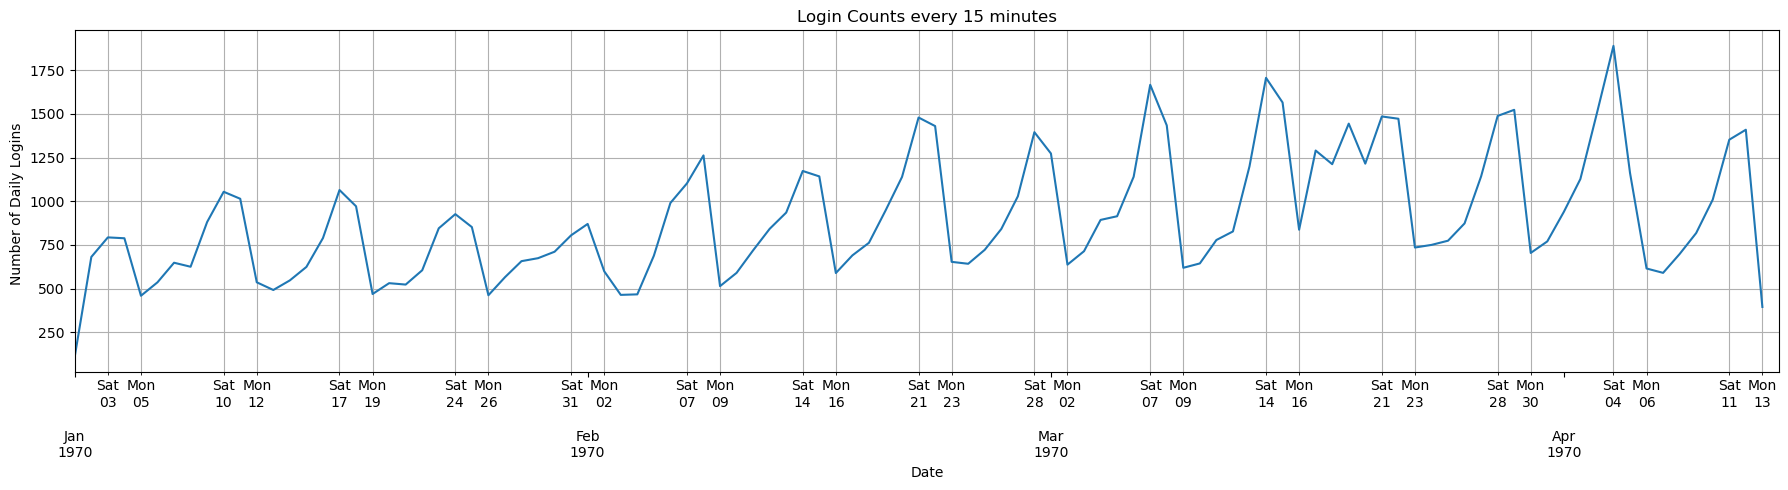

In [17]:
import matplotlib.dates as dates
fig, ax = plt.subplots(figsize = (18,5))
plt.plot(Daily_logins.index,Daily_logins.cnts)
plt.title('Login Counts every 15 minutes')
plt.ylabel('Number of Daily Logins ')
plt.xlabel('Date')
plt.xlim(pd.Timestamp('1970-01-01'),pd.Timestamp('1970-04-14'))

ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=([5,0]),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%a\n%d'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.show()

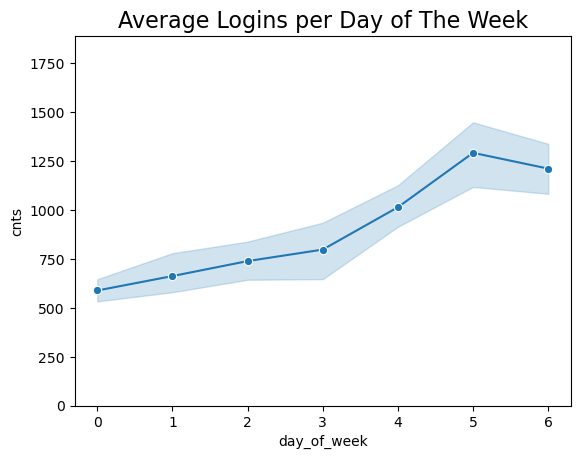

In [18]:
# Visualize average of logins per week.
sns.lineplot(data=Daily_logins, x='day_of_week', y='cnts',
            markers=True, marker='o')
plt.title('Average Logins per Day of The Week', fontsize=16)
ax = plt.gca()
#ax.set_xticks([1, 2, 3, 4])
#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr']) 
plt.ylim(0,max(Daily_logins.cnts))
plt.show()

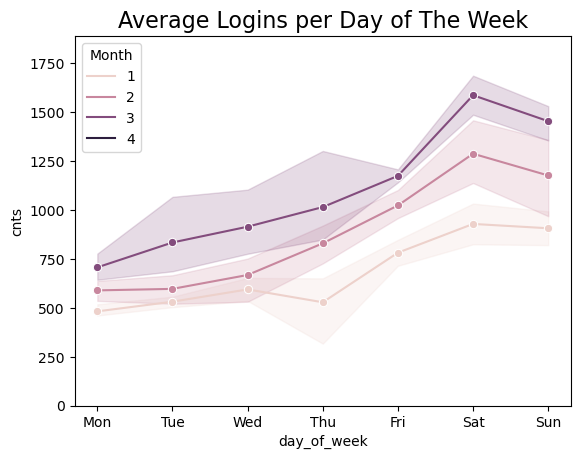

In [19]:
# Visualize average of logins per week.
sns.lineplot(data=Daily_logins[Daily_logins.Month<4], x='day_of_week', y='cnts',
            markers=True, marker='o', hue=Daily_logins.Month)
plt.title('Average Logins per Day of The Week', fontsize=16)
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) 
plt.ylim(0,max(Daily_logins.cnts))
plt.show()

In [20]:
Monthly_logins = logins.resample('M').sum()
Monthly_logins['Month'] = Monthly_logins.index.month

Monthly_logins

,cnts,Month
login_time,,
1970-01-31,21239,1
1970-02-28,24673,2
1970-03-31,33723,3
1970-04-30,13507,4


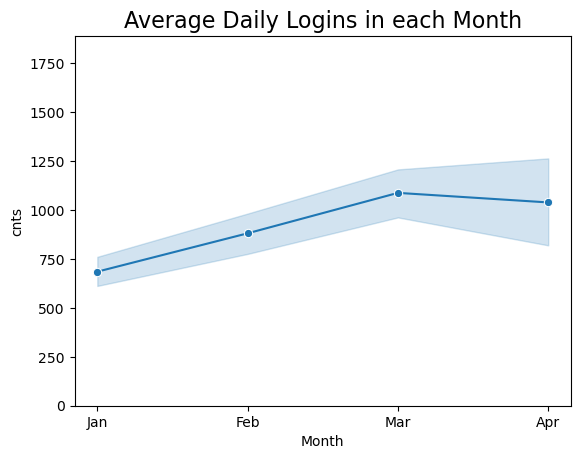

In [21]:
# Visualize average daily logins for each month.
sns.lineplot(data=Daily_logins, x='Month', y='cnts',
            markers=True, marker='o')
plt.title('Average Daily Logins in each Month', fontsize=16)
plt.ylim(0,max(Daily_logins.cnts))
ax = plt.gca()
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr']) 
plt.show()


## Part 2 ‐ Experiment and metrics design
**The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.**

**However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.**


#### Q1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Answer:
The key measure of success for this experiment in encouraging driver partners to serve both cities could be the percentage increase in the number of bridge crossings between Gotham and Metropolis. This metric would directly reflect the desired behavior change of driver partners being more available in both cities. By reimbursing toll costs, the goal is to remove the barrier that currently leads to driver partners being exclusive to one city. An increase in bridge crossings would indicate a successful shift towards driver partners being willing to operate in both cities, facilitating greater flexibility and availability for passengers.

#### Q2.Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
#### a) how you will implement the experiment
Answer: 
1. Select a representative sample of driver partners who primarily operate exclusively in either Gotham or Metropolis.

2. Announce and implement the toll reimbursement policy for a defined period (e.g., one month) and ensure clear communication to all driver partners.

3. Monitor and record the number of bridge crossings made by the selected driver partners during weekdays and weekends throughout the experimental period.

4. Collect additional data such as trip requests, driver partner availability, and passenger feedback to supplement the analysis.

#### b) what statistical test(s) you will conduct to verify the significance of the observation
Answer:

To determine the significance of the observation, we could employ a hypothesis test, specifically a paired t-test. The paired t-test would compare the mean number of bridge crossings by the selected driver partners before and after the implementation of the toll reimbursement policy. This test would account for the paired nature of the data, as each driver partner's crossings are measured before and after the policy change.

#### c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
Answer:
1. If the paired t-test reveals a statistically significant increase in the mean number of bridge crossings, it would indicate that the toll reimbursement policy has effectively encouraged driver partners to serve both cities. The results could be interpreted as evidence of the policy's success in increasing driver partner availability and reducing exclusivity to a single city.

2. However, it is essential to consider potential caveats, such as external factors (e.g., seasonality, holidays) that could impact bridge crossings and driver behavior. These factors should be taken into account during the interpretation of the results.

3. Based on the findings, recommendations could be made to the city operations team to continue implementing the toll reimbursement policy on a broader scale. Additionally, continuous monitoring and evaluation should be emphasized to ensure the long-term sustainability and effectiveness of the policy.


### Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

**Tasks:**
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).


In [22]:
users = pd.read_json('ultimate_data_challenge.json')
print(f'Shape of dataset: {users.shape}')
users.info()

Shape of dataset: (50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
missing=(users.isnull().sum() * 100 / len(users)).sort_values(ascending=False).head()
missingDF=missing.to_frame()
missingDF['number']=(users.isnull().sum()).sort_values(ascending=False).head()
missingDF

,0,number
avg_rating_of_driver,16.244,8122
phone,0.792,396
avg_rating_by_driver,0.402,201
city,0.000,0
trips_in_first_30_days,0.000,0


**avg_rating_of_driver has considerable number of missing values th erest are below 1% and can be dropped later**

In [24]:
users.nunique()

city                         3
trips_in_first_30_days      59
signup_date                 31
avg_rating_of_driver        37
avg_surge                  115
last_trip_date             182
phone                        2
surge_pct                  367
ultimate_black_user          2
weekday_pct                666
avg_dist                  2908
avg_rating_by_driver        27
dtype: int64

In [25]:
users.phone.unique(),users.city.unique()

(array(['iPhone', 'Android', None], dtype=object),
 array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object))

In [26]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [27]:
# convert dates to datetime objects
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])
# convert bool to int
users['ultimate_black_user'] = users['ultimate_black_user'].astype(int)

# Create new column for user retention
users['days_since_last_trip'] = (users['last_trip_date'].max() - users['last_trip_date']).dt.days
users['retained'] = (users['days_since_last_trip'] <= 30).astype(int)
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,14,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,57,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,175,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,2,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,108,0


In [28]:
# Fraction of observed useres retained
print(f"Fraction of the observed users that were retained: {users['retained'].mean() * 100:.1f} %")


Fraction of the observed users that were retained: 37.6 %


<AxesSubplot: xlabel='avg_rating_of_driver', ylabel='Count'>

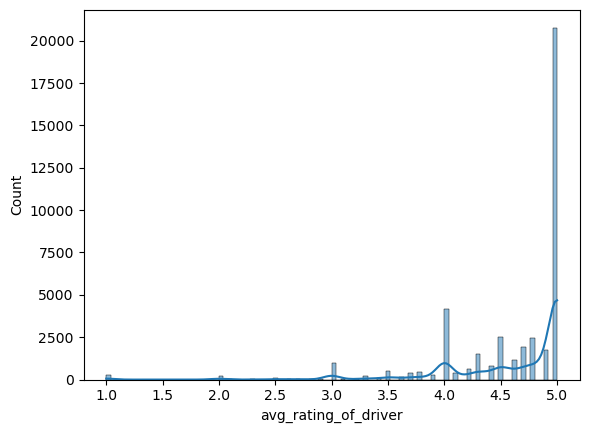

In [29]:
sns.histplot(users.avg_rating_of_driver,kde=True)

In [30]:
#users.avg_rating_of_driver.corr(users.avg_rating_by_driver)
users.avg_rating_of_driver.corr(users.retained)

-0.01165328857596876

In [31]:
users.avg_rating_of_driver.unique()
users.avg_rating_of_driver.mean()


4.601559291274655

Text(0.5, 1.0, 'Driver vs User ratings')

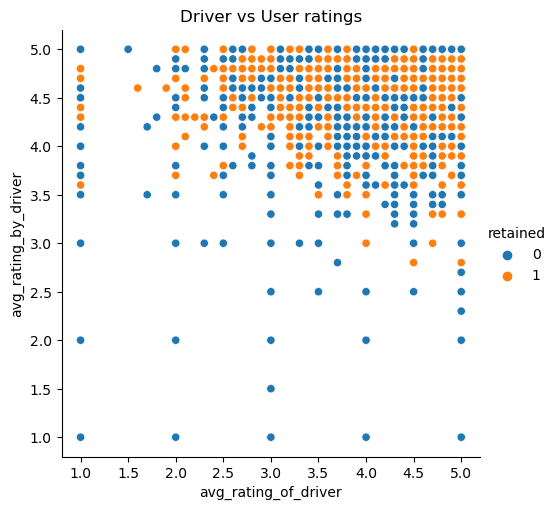

In [32]:
# scatter plot of average rating of driver vs average rating by driver
sns.relplot(x = 'avg_rating_of_driver', y = 'avg_rating_by_driver', data=users, hue='retained')
plt.title('Driver vs User ratings')


In [33]:

#Missing Values
print("##### Rating of Driver #####")

print(f"No Rating of Driver :{users[users.avg_rating_of_driver.isna()].retained.mean() * 100:.1f} % retained")
print(f"With Rating of Driver :{users[users.avg_rating_of_driver.notna()].retained.mean() * 100:.1f} % retained")

print(f"Low Rating of Driver :{users[users.avg_rating_of_driver<2.1].retained.mean() * 100:.1f} % retained")
print(f"High Rating of Driver :{users[users.avg_rating_of_driver>3.9].retained.mean() * 100:.1f} % retained")

print()
print("##### Rating by Driver #####")

print(f"No Rating by Driver :{users[users.avg_rating_by_driver.isna()].retained.mean() * 100:.1f} % retained")
print(f"With Rating by Driver :{users[users.avg_rating_by_driver.notna()].retained.mean() * 100:.1f} % retained")

print(f"Low Rating by Driver :{users[users.avg_rating_by_driver<2.1].retained.mean() * 100:.1f} % retained")
print(f"High Rating by Driver :{users[users.avg_rating_by_driver>3.9].retained.mean() * 100:.1f} % retained")


print()
print("##### Phone #####")

print(f"No phone :{users[users.phone.isna()].retained.mean() * 100:.1f} retained%")
print(f"With phone :{users[users.phone.notna()].retained.mean() * 100:.1f} retained%")

print(f"Android :{users[users.phone=='Android'].retained.mean() * 100:.1f} retained%")
print(f"iPhone :{users[users.phone=='iPhone'].retained.mean() * 100:.1f} retained%")



##### Rating of Driver #####
No Rating of Driver :20.1 % retained
With Rating of Driver :41.0 % retained
Low Rating of Driver :19.2 % retained
High Rating of Driver :40.9 % retained

##### Rating by Driver #####
No Rating by Driver :17.9 % retained
With Rating by Driver :37.7 % retained
Low Rating by Driver :12.5 % retained
High Rating by Driver :38.2 % retained

##### Phone #####
No phone :33.6 retained%
With phone :37.6 retained%
Android :20.9 retained%
iPhone :44.9 retained%


#### missing rating of driver have more of a retainer rate as of low ratings, I assign a new 0.9 value for this group rather than the average at 4.6. (They most likely didn't care for the driver to leave a rating) 

In [34]:
#fill missing values in  avg_rating_of_driver by a unique low value 
users.avg_rating_of_driver = users.avg_rating_of_driver.fillna(0.5)
users.dropna(axis=0, inplace=True)
users = users.reset_index(drop=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49406 entries, 0 to 49405
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  int64         
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  days_since_last_trip    49406 non-null  int64 

In [35]:
users[['signup_date','last_trip_date']].describe(datetime_is_numeric=True)

,signup_date,last_trip_date
count,49406,49406
mean,2014-01-16 12:54:30.210096128,2014-04-19 14:43:44.620491520
min,2014-01-01 00:00:00,2014-01-01 00:00:00
25%,2014-01-09 00:00:00,2014-02-15 00:00:00
50%,2014-01-17 00:00:00,2014-05-08 00:00:00
75%,2014-01-24 00:00:00,2014-06-18 00:00:00
max,2014-01-31 00:00:00,2014-07-01 00:00:00


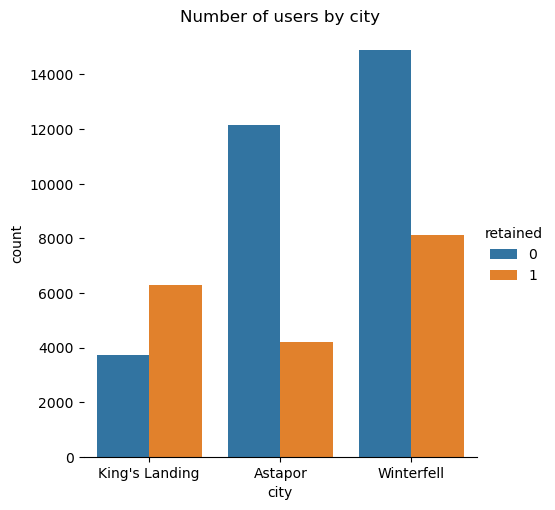

In [36]:
# number of users per each city
sns.set_palette('tab10')
sns.catplot(x = 'city', data = users, kind='count', hue='retained')
plt.title('Number of users by city')
sns.despine(left = True)


Text(0.5, 1.0, 'Users by ultimate_black_user')

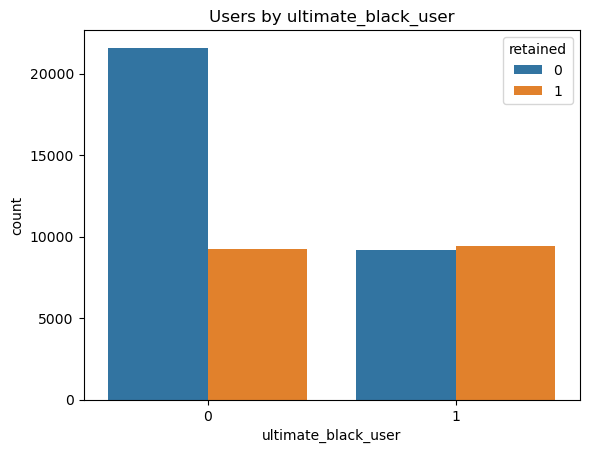

In [37]:
sns.countplot(x='ultimate_black_user', hue='retained', data=users)
plt.title('Users by ultimate_black_user')


Text(0.5, 1.0, 'Users by phone')

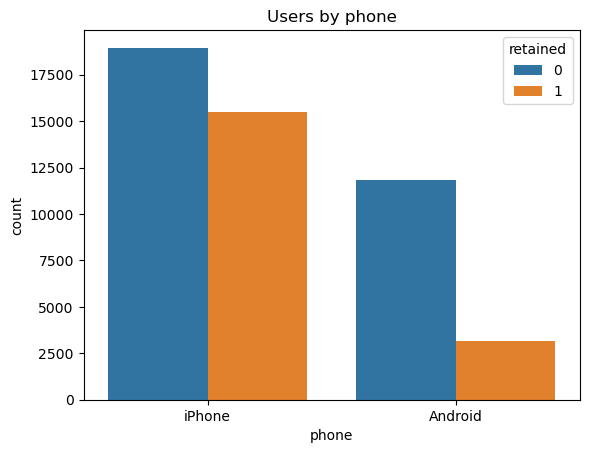

In [38]:
sns.countplot(x='phone', hue='retained', data=users)
plt.title('Users by phone')

Text(0.5, 1.0, 'Pairwise correlation coefficient')

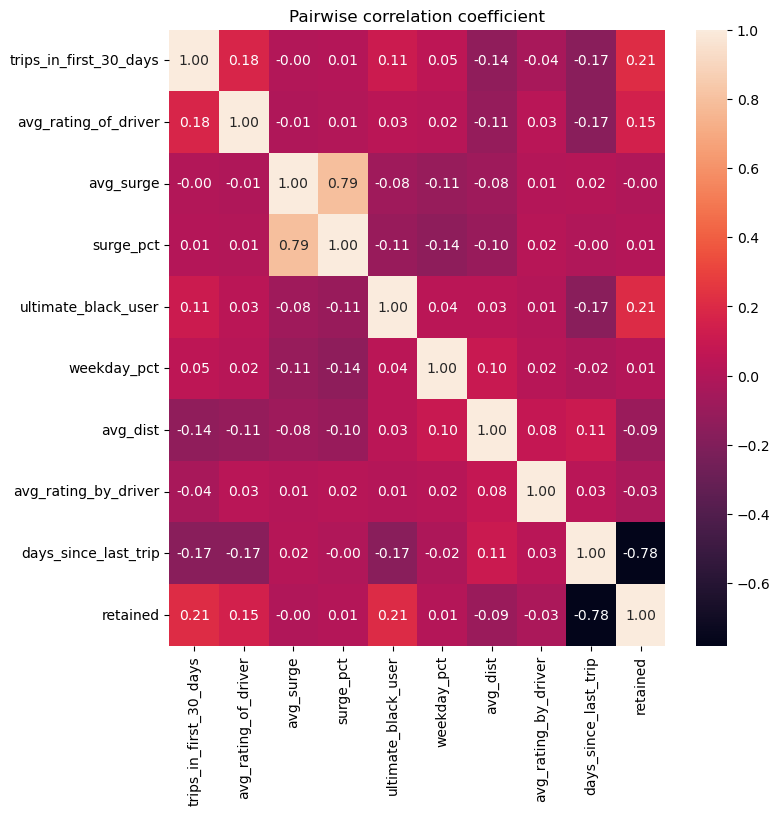

In [39]:
# heat map of correlation between all the variables in the data
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
sns.heatmap(users.corr(numeric_only=True), annot = True, fmt = '.2f', ax = ax)
plt.title('Pairwise correlation coefficient')

**From correlation table only "ultimate_black_user" and "trips_in_first_30_days" seems features with good predictive power for the target value**

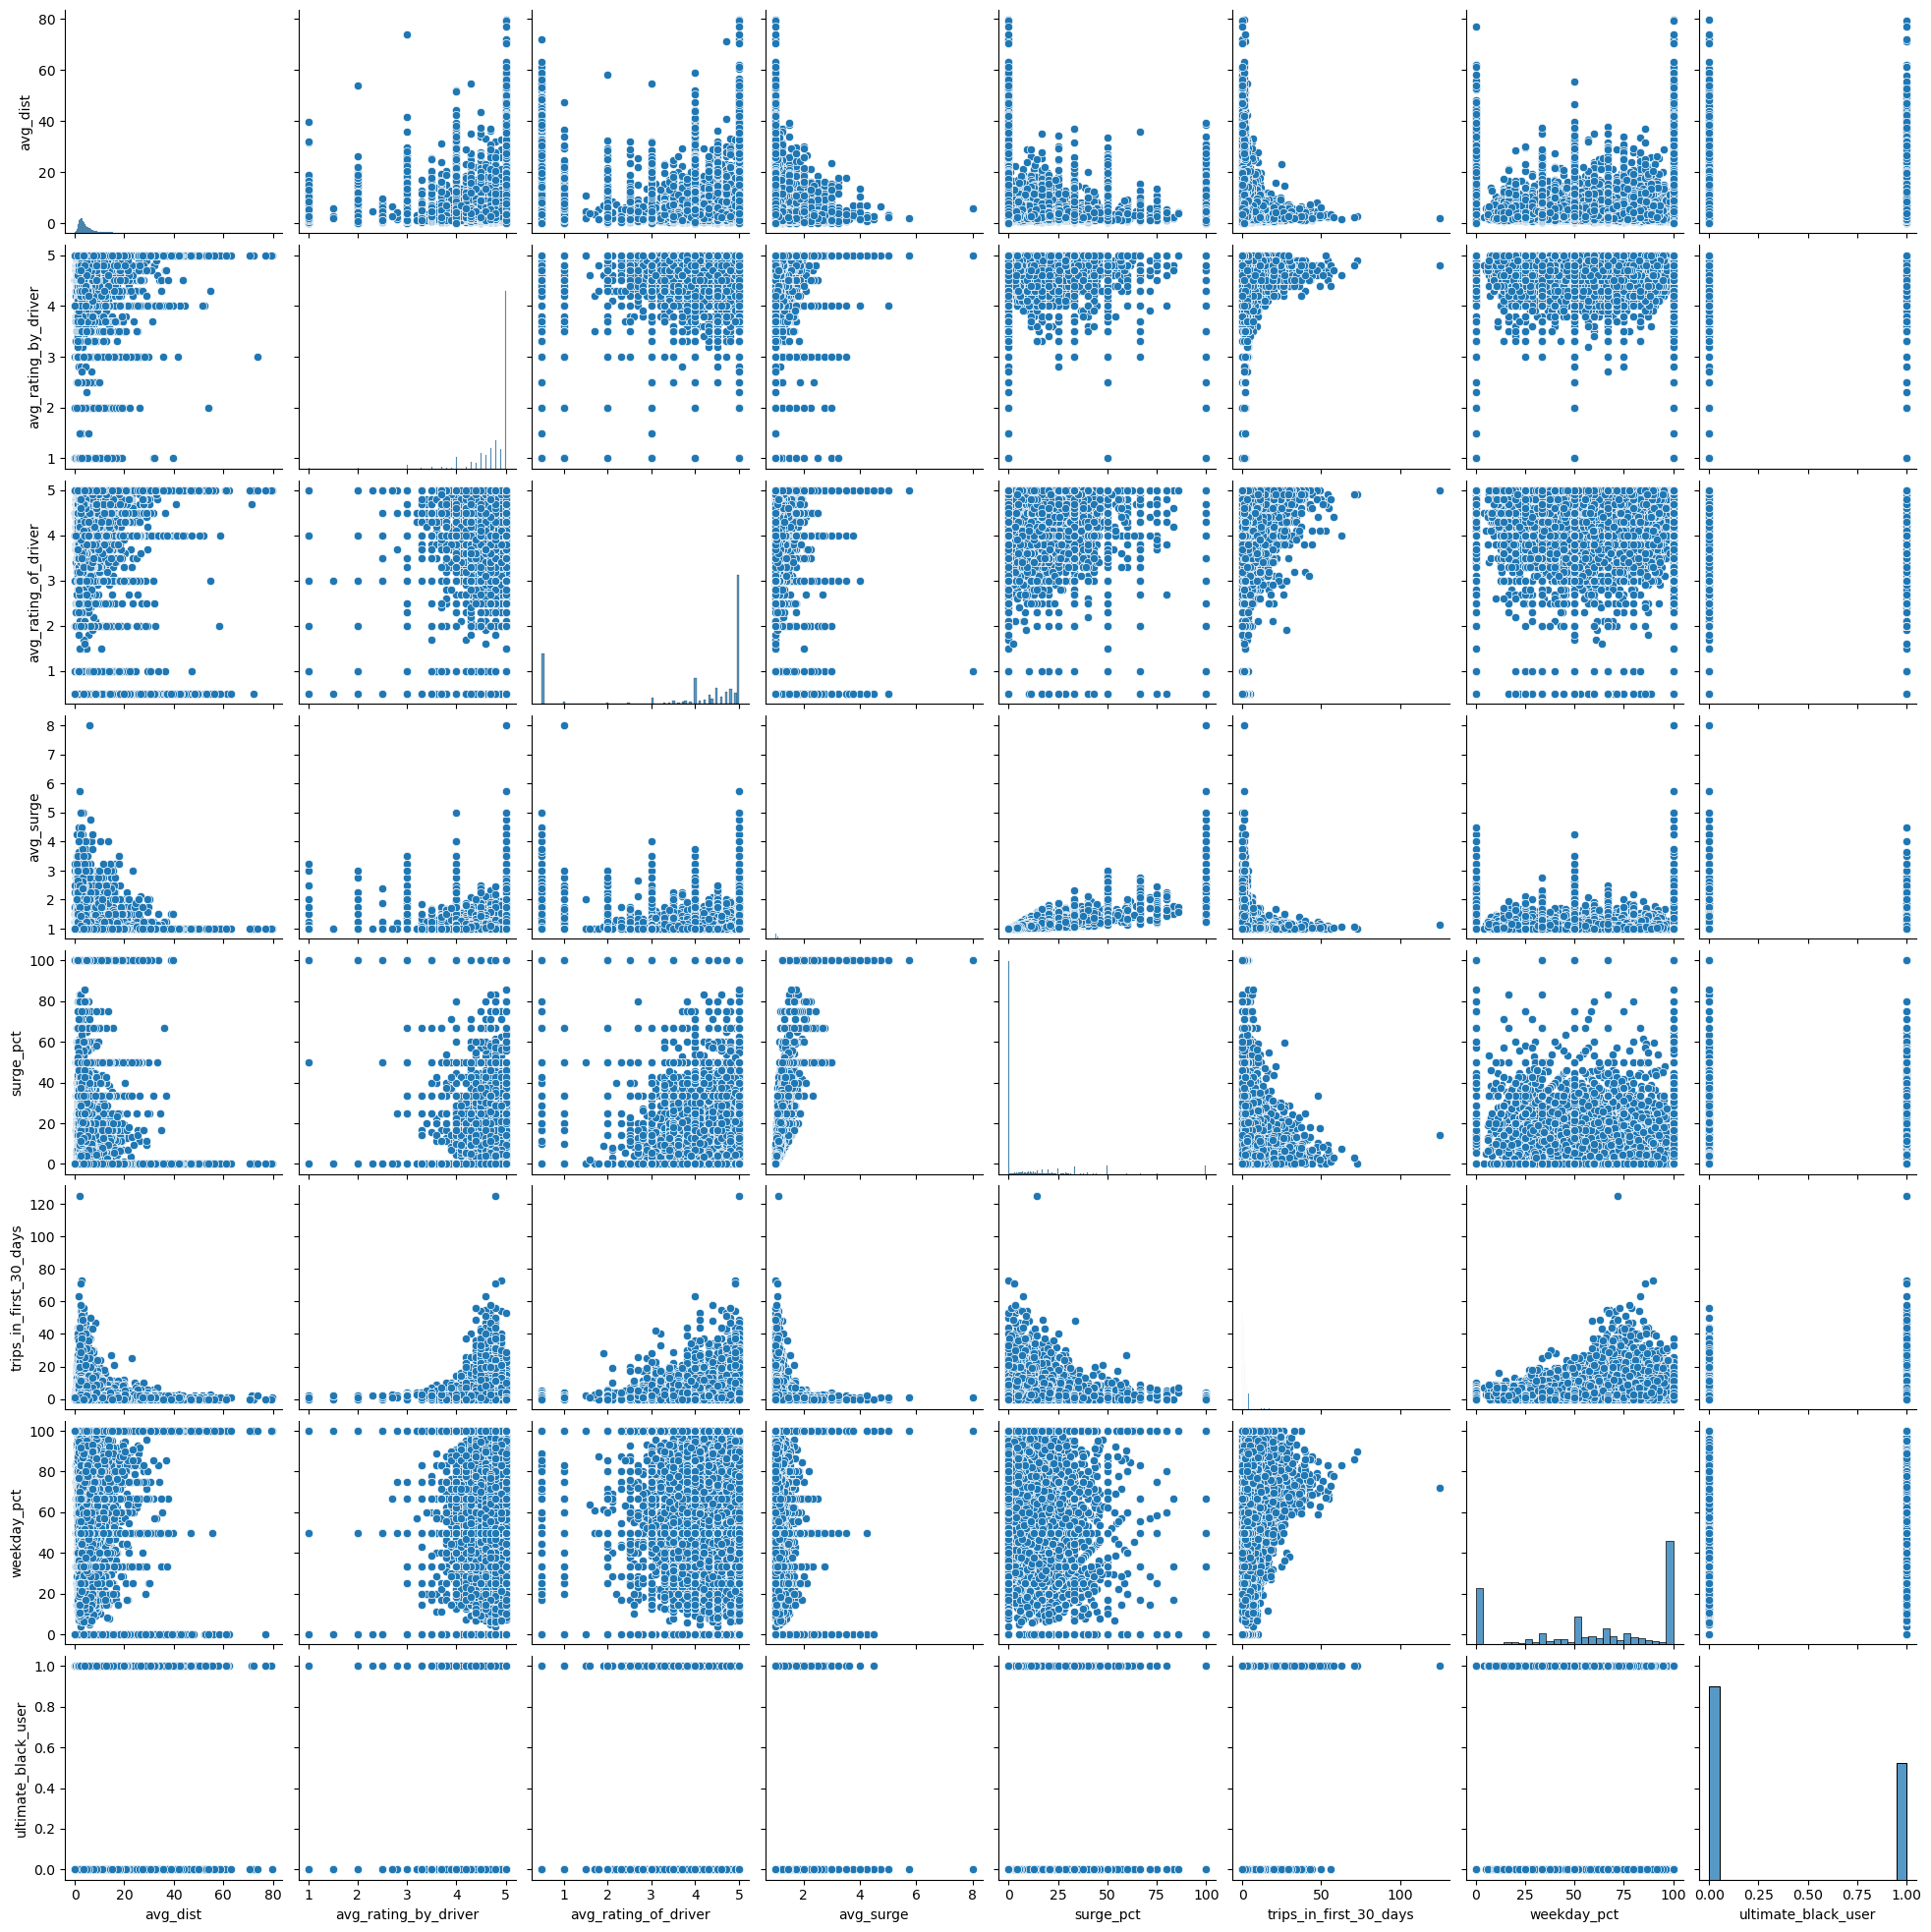

In [40]:
# a matrix of scatter plots between all the variable specified
sns.pairplot(users, vars = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                              'trips_in_first_30_days', 'weekday_pct', 'ultimate_black_user'])

### Models PreProcessing:

In [41]:
#From these columns you can directly find target value (how we get it so can't be used in predictive model
#                                                       (not available for new costumers)
users = users.drop(['last_trip_date', 'signup_date','days_since_last_trip'], axis =1)

def replace_with_dummies(df, columns):
    """
    Takes a df and a list of categorial columns with discrete values
    Returns a df with categorical columns replaced with binary columns
    """
    for col in columns:
        temp_df= df[[col]]
        temp_df = pd.get_dummies(temp_df)
        df[temp_df.columns] = temp_df
        df = df.drop(col, axis=1)
    return df


# using dummy variables instead of categorical data for 3 columns below
users_dummy = pd.get_dummies(users, columns = ['city', 'phone'], drop_first=True)

# one hot encode categorical columns
users = replace_with_dummies(users, ['city', 'phone'])

users_dummy.info()
#users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49406 entries, 0 to 49405
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49406 non-null  int64  
 1   avg_rating_of_driver    49406 non-null  float64
 2   avg_surge               49406 non-null  float64
 3   surge_pct               49406 non-null  float64
 4   ultimate_black_user     49406 non-null  int64  
 5   weekday_pct             49406 non-null  float64
 6   avg_dist                49406 non-null  float64
 7   avg_rating_by_driver    49406 non-null  float64
 8   retained                49406 non-null  int64  
 9   city_King's Landing     49406 non-null  uint8  
 10  city_Winterfell         49406 non-null  uint8  
 11  phone_iPhone            49406 non-null  uint8  
dtypes: float64(6), int64(3), uint8(3)
memory usage: 3.5 MB


In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49406 entries, 0 to 49405
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49406 non-null  int64  
 1   avg_rating_of_driver    49406 non-null  float64
 2   avg_surge               49406 non-null  float64
 3   surge_pct               49406 non-null  float64
 4   ultimate_black_user     49406 non-null  int64  
 5   weekday_pct             49406 non-null  float64
 6   avg_dist                49406 non-null  float64
 7   avg_rating_by_driver    49406 non-null  float64
 8   retained                49406 non-null  int64  
 9   city_Astapor            49406 non-null  uint8  
 10  city_King's Landing     49406 non-null  uint8  
 11  city_Winterfell         49406 non-null  uint8  
 12  phone_Android           49406 non-null  uint8  
 13  phone_iPhone            49406 non-null  uint8  
dtypes: float64(6), int64(3), uint8(5)
memo

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [44]:
# specifying predictors and targets
#X = users_dummy.drop(['last_trip_date', 'signup_date','days_since_last_trip','retained'], axis=1) #already omitted
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test) this is not right !!!

########## For Tree Based normal dummies
# this is one feature per cat
X = users.drop(['retained'], axis=1)
y = users['retained']#.values.reshape(-1, 1)

########### For regression SVM ... indipendent so drop first true
# this is drop_first=True  n-1 feature per n cat
Xd = users_dummy.drop(['retained'], axis=1)
yd = users_dummy['retained']#.values.reshape(-1, 1)


# dividing the data between training and the test set, taking care of imbalance with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state=82)
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = .2, stratify = y, random_state=82)


In [45]:
(y!=yd).sum()
(y_test!=yd_test).sum()   ## using the same random state we dont have to difrenciate between y and yd

0


### Train Random Forrest Classifier


In [46]:
rf = RandomForestClassifier()
# cross validation, dividing the data into 5 partitions 
cv_score = cross_val_score(rf, X_train, y_train)
cv_score

array([0.75711575, 0.75483871, 0.75142315, 0.75812777, 0.7458249 ])

In [47]:
rf.fit(X_train, y_train)
print("the accuracy resulting from random forst classifier:\n{:.2f}".format(rf.score(X_test, y_test)))

the accuracy resulting from random forst classifier:
0.76


In [48]:
y_pred = rf.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['not active', 'active' ],
                           columns = ['predicted not active', 'predicted active'])
conf_matrix


,predicted not active,predicted active
not active,5019,1136
active,1252,2475


In [49]:
print(classification_report(y_test, y_pred, target_names=['not active', 'active']))

              precision    recall  f1-score   support

  not active       0.80      0.82      0.81      6155
      active       0.69      0.66      0.67      3727

    accuracy                           0.76      9882
   macro avg       0.74      0.74      0.74      9882
weighted avg       0.76      0.76      0.76      9882



<BarContainer object of 13 artists>

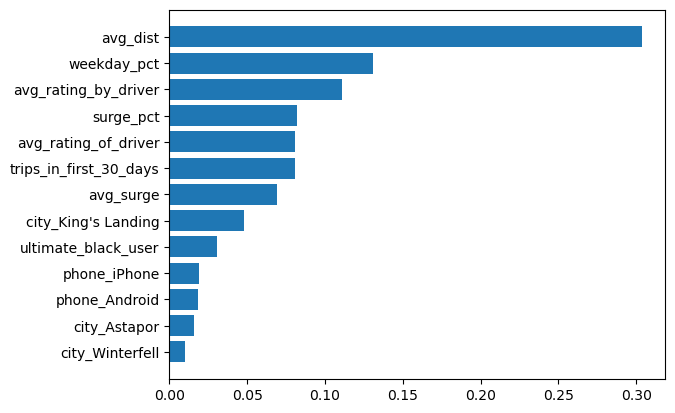

In [50]:
features, values = X.columns, rf.feature_importances_
feature_importances = list(zip(features, values))
feature_importances = sorted(feature_importances, key = lambda x: x[1])
features_sorted, importances_sorted = zip(*feature_importances)
plt.barh(features_sorted, importances_sorted)


In [51]:
def evaluate_classifier(model, X_test, y_test):
    
    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """
    
    # get predictions
    y_pred = model.predict(X_test)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()   
    
    
    # construct confusion matrix
    conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    conf_matrx.index = ['Actual: NO', 'Actual: YES']
    
    # get classification report
    report = classification_report(y_test, y_pred)
    
    return conf_matrx, report

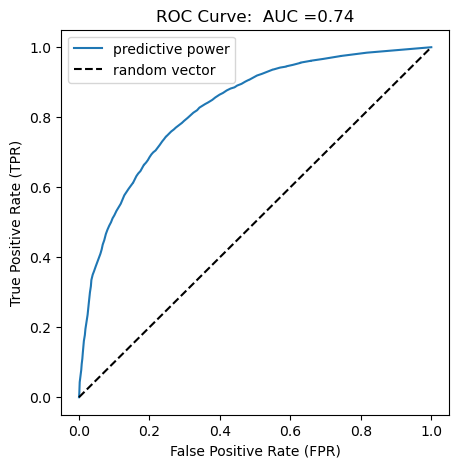

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6155
           1       0.69      0.66      0.67      3727

    accuracy                           0.76      9882
   macro avg       0.74      0.74      0.74      9882
weighted avg       0.76      0.76      0.76      9882



,Predict: NO,Predict: YES
Actual: NO,5019,1136
Actual: YES,1252,2475


In [52]:
# evaluate the random forest classifier
matrix, report = evaluate_classifier(rf, X_test, y_test)
print(report)
matrix


### Logistic Regression

In [53]:
models = {}
# Performance evaluation of each binary classifier
accuracy, precision, recall = {}, {}, {}


In [54]:
# Standardization for logistic regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xd_train)
Xds_train = scaler.transform(Xd_train)
Xds_test = scaler.transform(Xd_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=10000) #solver='lbfgs'


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Loop through models
for key in models.keys():
    # Fit classifier
    #models[key].fit(X_train_scaled, y_train)
    models[key].fit(Xds_train, yd_train)
    # Make predictions
    predictions = models[key].predict(Xds_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, yd_test)
    precision[key] = precision_score(predictions, yd_test)
    recall[key] = recall_score(predictions, yd_test)
    
# Create DataFrame with results
df_models = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_models['Accuracy'] = accuracy.values()
df_models['Precision'] = precision.values()
df_models['Recall'] = recall.values()
df_models.sort_values(by='Accuracy', ascending=False)

## Low precision might be due to outliers or non normal (skewed) distributions of numerical features

,Accuracy,Precision,Recall
Logistic Regression,0.723943,0.498793,0.683707


0.72


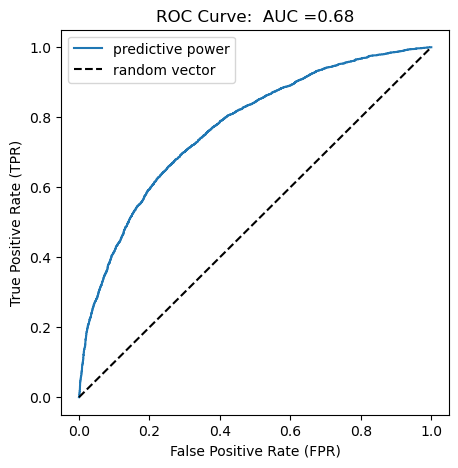

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      6155
           1       0.68      0.50      0.58      3727

    accuracy                           0.72      9882
   macro avg       0.71      0.68      0.69      9882
weighted avg       0.72      0.72      0.71      9882



,Predict: NO,Predict: YES
Actual: NO,5295,860
Actual: YES,1868,1859


In [56]:
lrm=models['Logistic Regression']
lrm.fit(Xds_train, yd_train)
y_pred_lr = lrm.predict(Xds_test)
print(round(accuracy_score(y_pred_lr, yd_test),2))
matrix, report = evaluate_classifier(lrm, Xds_test, yd_test)
print(report)
matrix


### KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier on the training data
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

#specify a parameter grid to search over
parameters = {
    'n_neighbors': [7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_cv = GridSearchCV(knn, parameters, cv=5) #specify GridSearchCV object

knn_cv.fit(X_train, y_train) #fit to training data

#find classifiers best parameters
print(knn_cv.best_params_)

y_pred = knn_cv.predict(X_test)

#check for accuracy improvement
print("New Accuracy:", knn_cv.score(X_test, y_test))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)


Accuracy: 0.7605747824327059
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
New Accuracy: 0.7695810564663024
Accuracy on test set: 0.7695810564663024


In [58]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

#knn_cv.score(y_train, y_pred)
knn_cv.score(X_test, y_test)


Accuracy on test set: 0.7695810564663024


0.7695810564663024

In [59]:
from sklearn.metrics import classification_report, confusion_matrix


print(classification_report(y_test, y_pred)) # print classification report and confusion matrix

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)


              precision    recall  f1-score   support

           0       0.79      0.85      0.82      6155
           1       0.72      0.64      0.68      3727

    accuracy                           0.77      9882
   macro avg       0.76      0.74      0.75      9882
weighted avg       0.77      0.77      0.77      9882

confusion matrix:
[[5238  917]
 [1360 2367]]


In [60]:
#pip install scikit-plot

/Users/kaveh/AppsFolder/anaconda3/envs/SPDS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


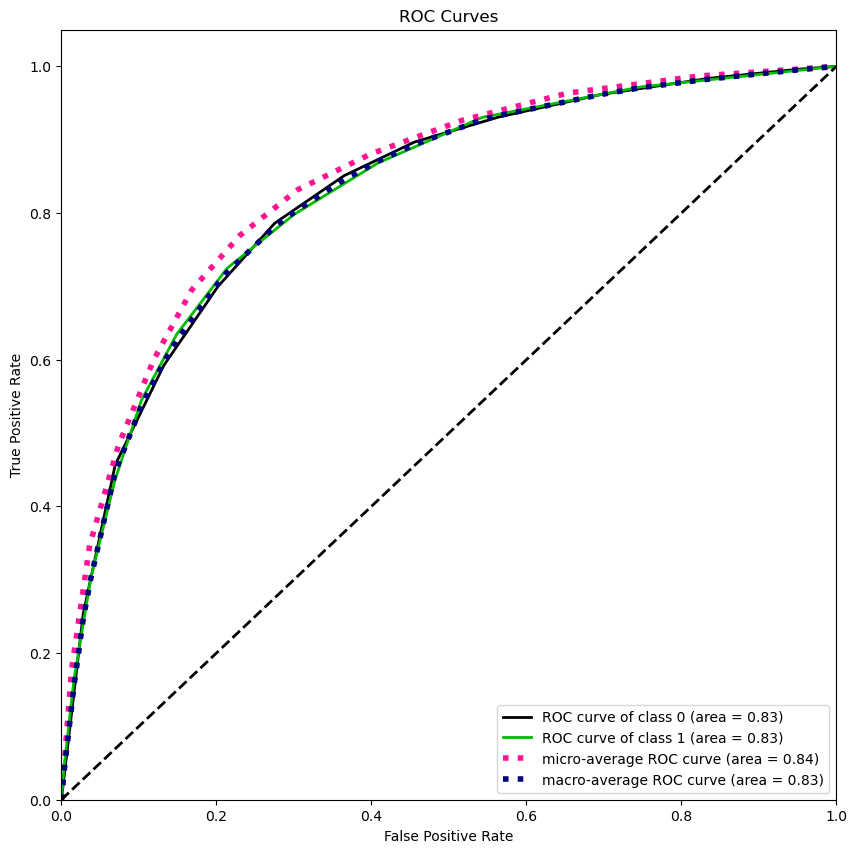

AUC score: 0.7430553427390132


In [61]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
#plot roc curve and  print AUV score
y_probas = knn_cv.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas, figsize=(10,10))
plt.show()
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))




### XGBOOST

In [62]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_depth': [5,8],
    'scale_pos_weight':[0.9],
    'subsample':[0.9,1],#fraction of observations to be random samples for each tree
    'learning_rate': [0.2, 0.1],
#    'min_child_weight':[0,1], 
    'gamma':[1, 2] #Gamma specifies the minimum loss reduction required to make a split. 
    }

In [63]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 82, n_estimators=10)#, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=10, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=82, ...),
             param_grid={'gamma': [1, 2], 'learning_rate': [0.2, 0.1],
                         'max_depth': [5, 8], 'scale_pos_weight': [0.9],
                         'subsample': [0.9, 1]},
             scoring='accuracy')

In [64]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)


{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 8, 'scale_pos_weight': 0.9, 'subsample': 1}
0.7818032775340775


In [65]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 82,
                     #   'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.9, 
                     #   'min_child_weight': 0, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 1
                       }
# instantiate classifier
xg_clf_best = XGBClassifier(**optimized_parameters)
xg_clf_best.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=82, ...)

In [66]:
# predict the labels
y_pred_best = xg_clf_best.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_pred_best)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,2)))


The resulting accuracy of the optimized classifier for the test set is 0.79.


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

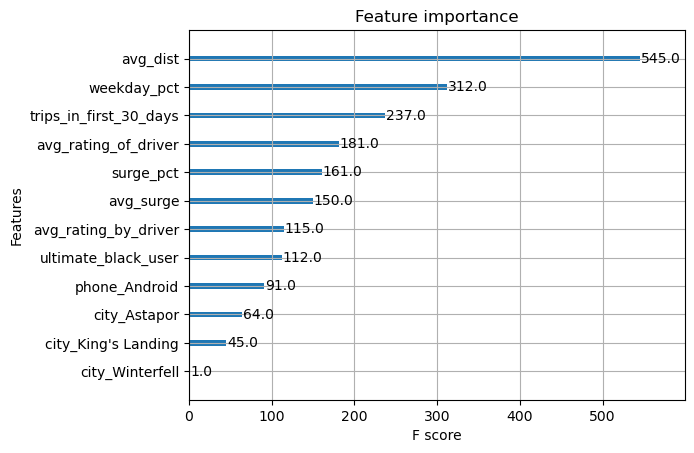

In [67]:
plot_importance(xg_clf_best)

In [68]:
print(classification_report(y_test, y_pred_best, target_names=['Left', 'Retained']))

              precision    recall  f1-score   support

        Left       0.80      0.88      0.84      6155
    Retained       0.76      0.64      0.69      3727

    accuracy                           0.79      9882
   macro avg       0.78      0.76      0.76      9882
weighted avg       0.78      0.79      0.78      9882



In [69]:
#ROC Score
fpr, tpr, thresholds = roc_curve(y_train, xg_clf_best.predict_proba(X_train)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, xg_clf_best.predict_proba(X_test)[:, 1])

auc = roc_auc_score(y_train, xg_clf_best.predict_proba(X_train)[:, 1])
auc2 = roc_auc_score(y_test, xg_clf_best.predict_proba(X_test)[:, 1])
print("AUC: {:.3}".format(auc2))


AUC: 0.856


Text(0.5, 1.0, 'ROC curve')

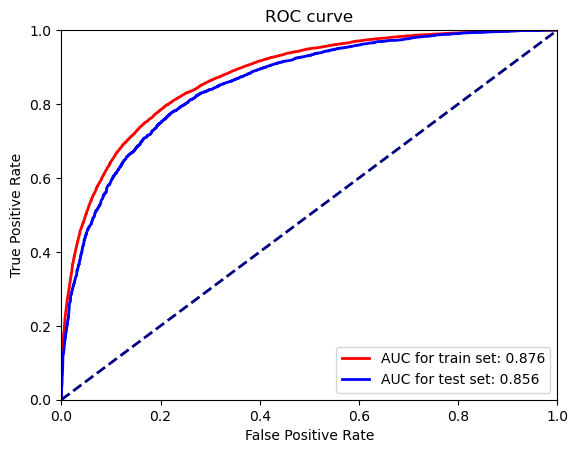

In [70]:
plt.plot(fpr, tpr, color='red', lw=2, label='AUC for train set: {:.3f}'.format(auc))
plt.plot(fpr2, tpr2, color='blue', lw=2, label='AUC for test set: {:.3f}'.format(auc2))

plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')

<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

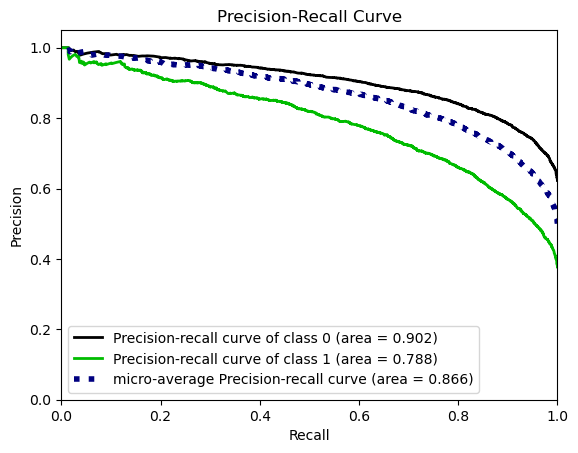

In [72]:
probas = xg_clf_best.predict_proba(X_test)
skplt.metrics.plot_precision_recall_curve(y_test, probas)

Based on the model's insights, Ultimate could take actions such as offering promotions or optimizing their product and marketing strategies to better retain users. The goal is to use the model's findings to personalize and tailor the user experience and ultimately increase rider retention.